# Downstream prediction 

Run this notebook on google colab to use a free GPU! 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Hyena-DNA-Inference.ipynb)

In this notebook, a HyenaDNA model is used for various classifications tasks with a given sequence of nucleotides.

A HyenaDNA model (2 layers and width 256) is used to create embeddings of nucleotides.

A neural network is then trained, using the embeddings as inputs, to make a prediction.

This notebook can be used for any of the 18 [nucleotide transformer downstream tasks](https://huggingface.co/datasets/InstaDeepAI/nucleotide_transformer_downstream_tasks).

In [16]:
# !pip install helical

  Running command git clone --filter=blob:none --quiet https://github.com/helicalAI/helical.git /private/var/folders/pm/76n9tjdj18z7cbc55rk10yfw0000gn/T/pip-req-build-oa9zv4bw


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datasets import DatasetDict
import datetime
import torch
from tqdm import tqdm
from typing import Tuple
import logging, warnings

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

2024-09-30 17:44:04.360305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 17:44:04.369540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 17:44:04.378786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 17:44:04.381519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 17:44:04.389495: I tensorflow/core/platform/cpu_feature_guar

2024-09-30 17:44:04.844402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Use the Helical package to get the Hyena model
We use a small HyenaDNA model with 2 layers and width 256.

In [2]:
from helical.models.hyena_dna.model import HyenaDNA
from helical.models.hyena_dna.hyena_dna_config import HyenaDNAConfig  
device = "cuda" if torch.cuda.is_available() else "cpu"
configurer = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256", device=device, batch_size=5)
hyena_model = HyenaDNA(configurer=configurer)

/home/matthew/helical-dev/helical/helical/models/scgpt/model_dir/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
INFO:helical.services.downloader:File: '/home/matthew/.cache/helical/models/hyena_dna/hyenadna-tiny-1k-seqlen-d256.ckpt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/home/matthew/.cache/helical/models/hyena_dna/hyenadna-tiny-1k-seqlen-d256.ckpt'
INFO:helical.models.hyena_dna.pretrained_model:Loaded pretrained weights ok!
INFO:helical.models.hyena_dna.model:Model finished initializing.


### Download the dataset
Several datasets are available from the [Nucleotide Transformer](https://arxiv.org/abs/2306.15794). Using the `get_dataset_config_names()` function, we get a list of the available the datasets for the downstream tasks.

In [3]:
from datasets import get_dataset_config_names

configs = get_dataset_config_names("InstaDeepAI/nucleotide_transformer_downstream_tasks", trust_remote_code=True)
configs

['H4ac',
 'H3K36me3',
 'splice_sites_donors',
 'splice_sites_acceptors',
 'H3',
 'H4',
 'H3K4me3',
 'splice_sites_all',
 'H3K4me1',
 'H3K14ac',
 'enhancers_types',
 'promoter_no_tata',
 'H3K79me3',
 'H3K4me2',
 'promoter_tata',
 'enhancers',
 'H3K9ac',
 'promoter_all']

We can select any of the 18 downstream tasks. Let us take the `promoter_tata` as an example.

In [4]:
from datasets import load_dataset
label = "promoter_tata"
dataset = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks", label, trust_remote_code=True)

To familiarize ourselves with the data, we can print the first seqence and see if it is a splice site acceptor or not:

In [5]:
print("Nucleotide sequence:", dataset["train"]["sequence"][0][:10], "...")
print("Label name:", dataset["train"].config_name, "and value:", dataset["train"]["label"][0])
num_classes = len(set(dataset["train"]["label"]))
print("Number of classes:", num_classes)

Nucleotide sequence: CGCTCCCCCA ...
Label name: promoter_tata and value: 0
Number of classes: 2


Define a function that gets the embeddings for each nucleotide sequence in the training dataset.

According to the HyenaDNA [paper](https://arxiv.org/pdf/2306.15794): "[they] average across the tokens to obtain a single classification token".

In our code below, the Hyena model returns a (302, 256) matrix. We average column wise resulting in a vector of shape (256, ) for each observation.

During the training process, we also found that it is beneficial to normalize the data row-wise.

In [6]:
def get_model_inputs(dataset: DatasetDict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    dataset : DatasetDict
        The dataset containing the sequences and labels.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the input features and labels.
    """
    processed_data = hyena_model.process_data(dataset["sequence"])

    embeddings = hyena_model.get_embeddings(processed_data)
    embeddings = embeddings.mean(axis=1)
    means = np.mean(embeddings, axis=1, keepdims=True)
    stds = np.std(embeddings, axis=1, keepdims=True)

    x = (embeddings - means) / stds

    return x, dataset["label"]

It may be beneficial to do this step once and save the output in a `.npy` file.

In [8]:
x, y = get_model_inputs(dataset["train"])
#np.save(f"data/train/x_{label}_norm_256", x)
#np.save(f"data/train/y_{label}_norm_256", y)

INFO:helical.models.hyena_dna.model:Processing data
Processing sequences: 100%|██████████| 5509/5509 [00:00<00:00, 10331.56it/s]
INFO:helical.models.hyena_dna.model:Data processing finished.
INFO:helical.models.hyena_dna.model:Inference started
Getting embeddings: 100%|██████████| 1102/1102 [00:01<00:00, 606.64it/s]


Load the data and one-hot-encode the labels.

We split the training set into actual training data and a test set. 

This is optional and the entire dataset can be used for training. We did this to avoid data leakage by not touching the test set during the training process.

In [9]:
#x = np.load(f"data/train/x_{label}_norm_256.npy")
#y = np.load(f"data/train/y_{label}_norm_256.npy")

# # One-hot encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=num_classes)
y_encoded
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.1, random_state=42)

### Define and train the model

In [10]:
input_shape = (configurer.config['d_model'],)

# define the model
head_model = Sequential()
head_model.add(Dense(256, activation='relu', input_shape=input_shape))
head_model.add(Dropout(0.4)) 
head_model.add(Dense(128, activation='relu'))
head_model.add(Dropout(0.4))
head_model.add(Dense(128, activation='relu'))
head_model.add(Dropout(0.4))  
head_model.add(Dense(64, activation='relu'))
head_model.add(Dropout(0.4))  
head_model.add(Dense(num_classes, activation='softmax'))

# compile the model
optimizer = Adam(learning_rate=0.001)

head_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
head_model.summary()

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = head_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

/home/matthew/miniconda3/envs/helical-dev/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727711071.312412 1848296 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727711071.314627 1848296 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727711071.315966 1848296 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,586 (482.76 KB)

 Trainable params: 123,586 (482.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25


I0000 00:00:1727711073.129685 1848553 service.cc:146] XLA service 0x7b6504005ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727711073.129707 1848553 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-30 17:44:33.147607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-30 17:44:33.233553: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


68/78 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.7839

I0000 00:00:1727711074.391854 1848553 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.7765 - val_loss: 0.6899
Epoch 2/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6960 - val_loss: 0.6799
Epoch 3/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6770 - val_loss: 0.6013
Epoch 4/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5919 - val_loss: 0.4149
Epoch 5/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4671 - val_loss: 0.3438
Epoch 6/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4267 - val_loss: 0.3105
Epoch 7/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3886 - val_loss: 0.3123
Epoch 8/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4019 - val_loss: 0.2902
Epoch 9/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4156 - val_loss: 0.2799
Epoch 10/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4017 - val_loss: 0.3112
Epoch 11/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3943 - val_loss: 0.2919
Epoch 12/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3970 - val_loss: 0.3130

In [12]:
X_unseen, y_unseen = get_model_inputs(dataset["test"])
#np.save(f"data/test/x_{label}_norm_256.npy")
#np.save(f"data/test/y_{label}_norm_256.npy")

INFO:helical.models.hyena_dna.model:Processing data
Processing sequences: 100%|██████████| 621/621 [00:00<00:00, 10475.13it/s]
INFO:helical.models.hyena_dna.model:Data processing finished.
INFO:helical.models.hyena_dna.model:Inference started
Getting embeddings: 100%|██████████| 125/125 [00:00<00:00, 637.68it/s]


### Evaluate the model on the test data


In [13]:
#X_unseen = np.load(f"data/test/x_{label}_norm_256.npy")
#y_unseen = np.load(f"data/test/y_{label}_norm_256.npy")

predictions_nn = head_model.predict(X_unseen)

y_pred = np.argmax(predictions_nn, axis=1)
print("Correct predictions: {:.2f}%".format(sum(np.equal(y_pred, y_unseen))*100/len(y_unseen)))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 
Correct predictions: 90.18%


The [Hyena](https://arxiv.org/pdf/2306.15794) and the [Nucleotide transformer](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf) papers, report accuracies around 95% for this task. Our results underperform in comparison. This is probably due to the much larger models being used for the NT, while the Hyena model was re-trained from scratch for this task. In future work, we want to achieve these accuracies too with either approaches.

## OPTIONAL
For reference, we also trained an SVM model and obtained similar results (to our small NN).

In [14]:
# Train the SVM model
svm_model = svm.SVC(kernel='rbf', degree=3, C=1, decision_function_shape='ovr')  # One-vs-rest strategy
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=1)

In [15]:
# Evaluate the model
unseen_predictions_svm = svm_model.predict(X_unseen)

accuracy = accuracy_score(y_unseen, unseen_predictions_svm)
print("Test accuracy: {:.1f}%".format(accuracy*100))


Test accuracy: 89.7%


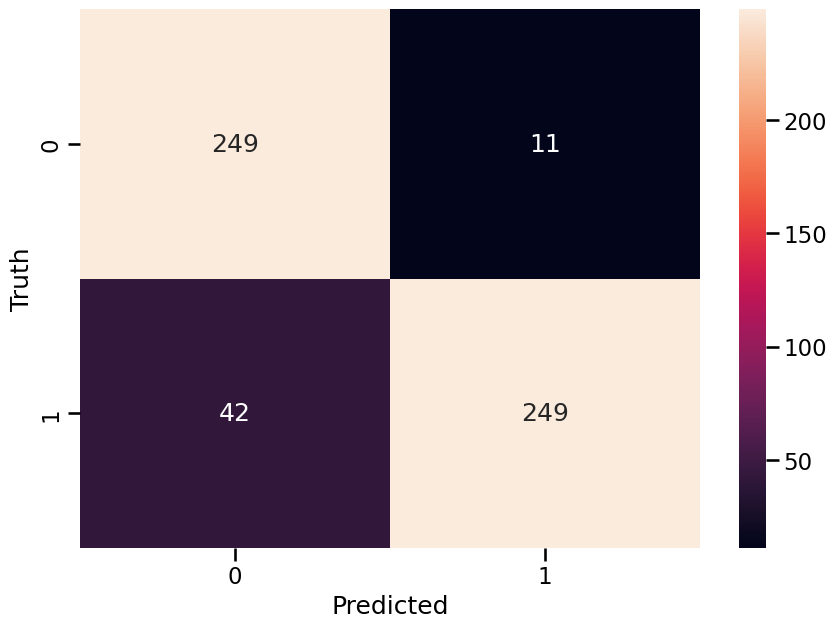

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# NN
# y_true = np.argmax(y_test, axis=1)
# y_pred_classes = np.argmax(predictions_nn, axis=1)

# SVM
y_true = y_test
y_pred_classes = svm_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()